In [2]:
#libraries for clustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
df = pd.read_csv("B.HEALTH_classification.csv")
base_df = df.drop(columns=["subject","day", "label"])

In [4]:
def cluster_ac(x, n_clusters):
    ac = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ac.fit(x)
    return ac.labels_

In [5]:
def cluster_DBSCAN(x, eps):
    db = DBSCAN(metric='euclidean', eps=eps)
    db.fit(x)
    return db.labels_

In [6]:
def cluster_kmeans(x, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=17).fit(x)
    return kmeans.labels_

In [7]:
def normalize_data(x, how='minmax'):
    match how:
        case 'minmax':
            scaler = MinMaxScaler()
            return scaler.fit_transform(x)
        case 'standard':
            scaler = StandardScaler()
            return scaler.fit_transform(x)
        case 'none':
            return x

In [8]:
def reduce_df(X, n_components=2, how='pca'):
    match how:
        case 'pca':
            redux = PCA(n_components)
            return redux.fit_transform(X)
        case 'tsne':
            redux = TSNE(n_components)
            return redux.fit_transform(X)
        case 'none':
            return X

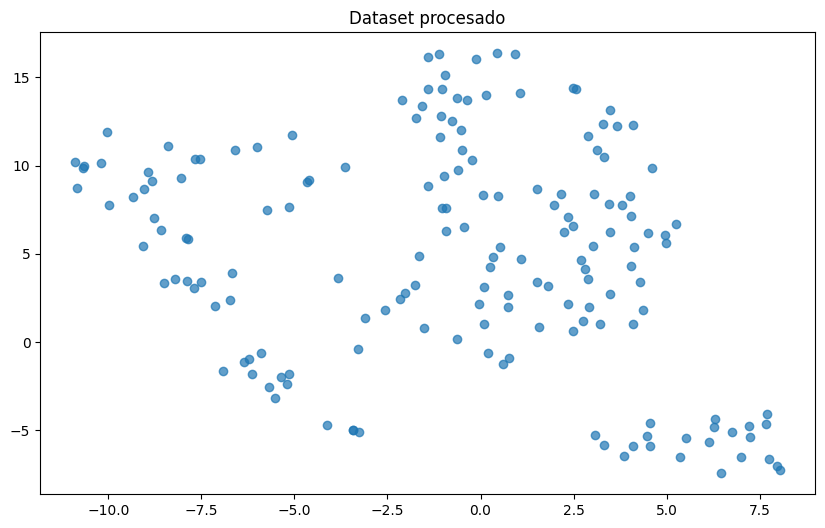

In [9]:
# Normalize the dataset
x_normalized = normalize_data(base_df, how='minmax')

# Reduce dimensions using TSNE
x_reduced = reduce_df(x_normalized, n_components=10, how='pca')

x_reduced_plot = reduce_df(x_normalized, n_components=2, how='tsne')

# Scatter plot of the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced_plot[:, 0], x_reduced_plot[:, 1], alpha=0.7)
plt.title('Dataset procesado')
plt.show()

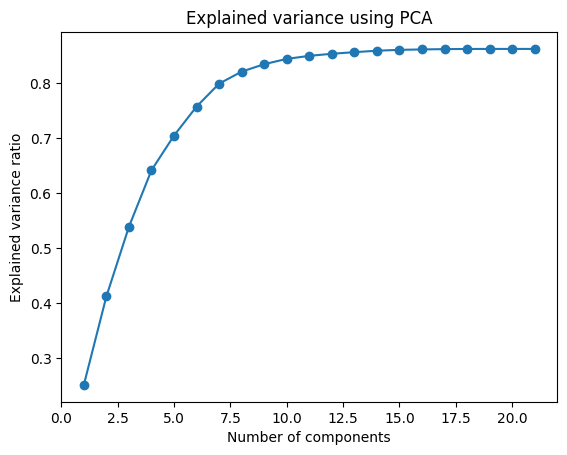

In [10]:
# Plot explained variance using PCA
pca = PCA(n_components=21)
pca_reduced = pca.fit_transform(x_normalized)
plt.plot(range(1, 22), np.cumsum(pca.explained_variance_), marker='o')
plt.title('Explained variance using PCA')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.show()

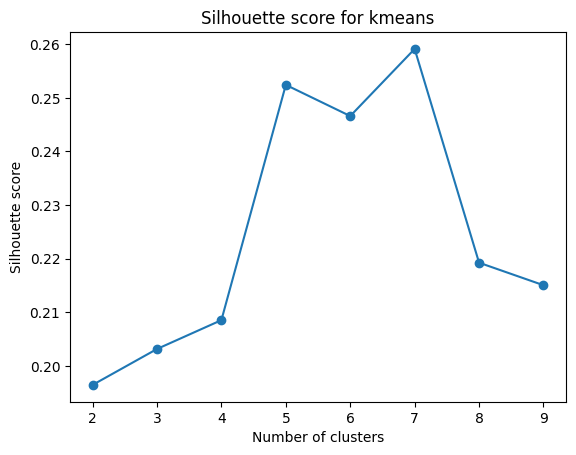

In [11]:
# Plot silhouette score for kmeans
silhouette_scores = []
for n_clusters in range(2, 10):
    kmeans_labels = cluster_kmeans(x_reduced, n_clusters=n_clusters)
    silhouette_avg = silhouette_score(x_reduced, kmeans_labels)
    silhouette_scores.append(silhouette_avg)
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette score for kmeans')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

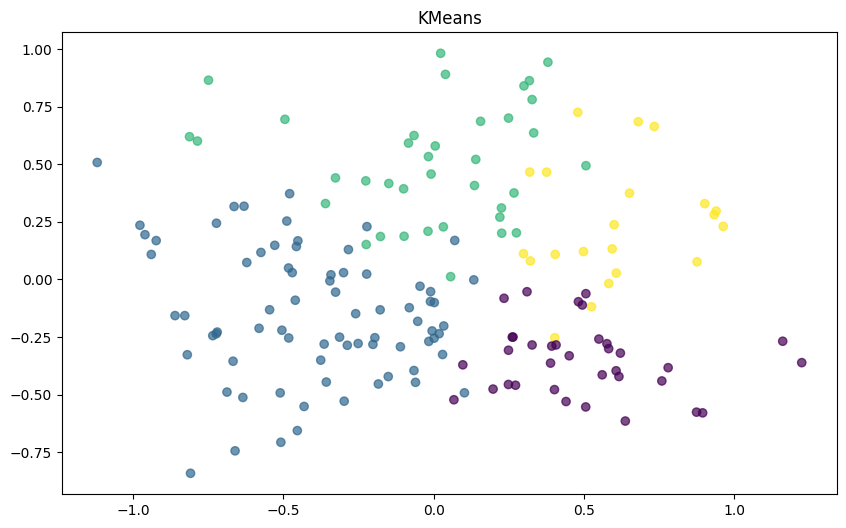

In [12]:
# Clusterize using KMeans
kmeans_labels = cluster_kmeans(x_reduced, n_clusters=4)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=kmeans_labels, alpha=0.7)
plt.title('KMeans')
plt.show()

In [54]:
# Copy base dataset, normalize values and add labels back
labeled_df = base_df.copy()
labeled_df = labeled_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
labeled_df['label'] = df['label']

In [55]:
# Print standard deviation and label count for each cluster
def print_cluster_stats(labeled_df, labels):
    for cluster_num in np.unique(labels):
        cluster_data = labeled_df[labels == cluster_num]
        
        if cluster_num == -1:
            print("Noise: ", len(cluster_data), "instances")
            continue
        
        print(f"Cluster {cluster_num}:")
        std_dev = cluster_data.std()
        print("Variance for each variable:")
        print(std_dev)
        print("\nLabel count:")
        print(cluster_data['label'].value_counts())

        print("\n")

In [56]:
print_cluster_stats(labeled_df, kmeans_labels)

Cluster 0:
Variance for each variable:
step count                                0.065185
distance travelled (km)                   0.077931
calories burnt (kcal)                     0.056157
acive time (minutes)                      0.065994
actual sleep duration (minutes)           0.125197
sleep onset latency (minutes)             0.224887
duration in bed (minutes)                 0.140028
efficiency (%)                            0.164576
in bed time                               0.078876
out bed time                              0.128915
in bed awake duration (minutes)           0.224887
light sleep duration (minutes)            0.146923
deep sleep duration (minutes)             0.103100
REM duration (minutes)                    0.121410
awake percentage (%)                      0.207234
light sleep percentage (%)                0.155299
deep sleep percentage (%)                 0.148832
REM percentage (%)                        0.057803
total phone usage / day (minutes)         0

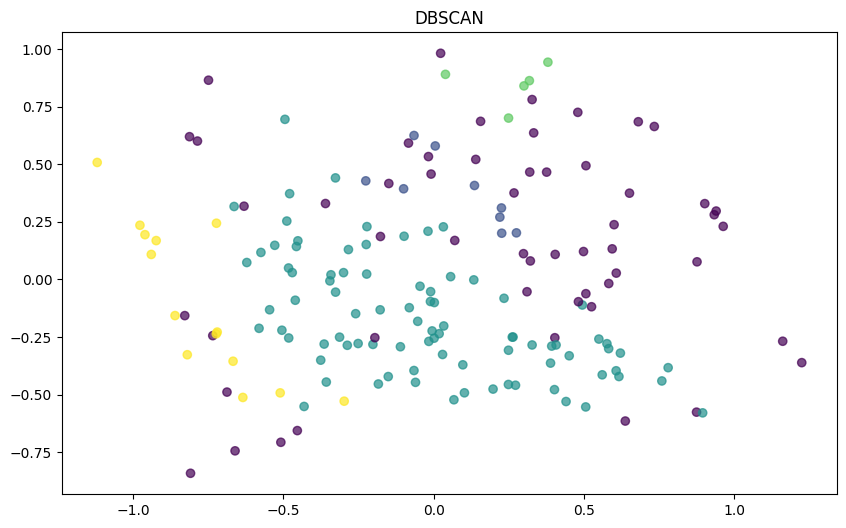

In [57]:
# Clusterize using DBSCAN
dbscan_labels = cluster_DBSCAN(x_reduced, 0.5)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=dbscan_labels, alpha=0.7)
plt.title('DBSCAN')
plt.show()

In [58]:
print_cluster_stats(labeled_df, dbscan_labels)


Noise:  54 instances
Cluster 0:
Variance for each variable:
step count                                0.080135
distance travelled (km)                   0.098106
calories burnt (kcal)                     0.054210
acive time (minutes)                      0.109073
actual sleep duration (minutes)           0.047634
sleep onset latency (minutes)             0.080797
duration in bed (minutes)                 0.058833
efficiency (%)                            0.142477
in bed time                               0.054442
out bed time                              0.092161
in bed awake duration (minutes)           0.080797
light sleep duration (minutes)            0.046691
deep sleep duration (minutes)             0.038274
REM duration (minutes)                    0.102500
awake percentage (%)                      0.054880
light sleep percentage (%)                0.065047
deep sleep percentage (%)                 0.050001
REM percentage (%)                        0.092111
total phone usage / da

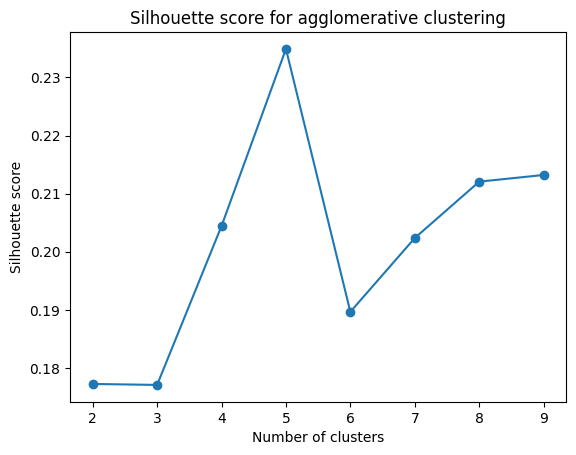

In [59]:
# Plot silhouette score for agglomerative clustering
silhouette_scores = []
for n_clusters in range(2, 10):
    agglomerative_labels = cluster_ac(x_reduced, n_clusters=n_clusters)
    silhouette_avg = silhouette_score(x_reduced, agglomerative_labels)
    silhouette_scores.append(silhouette_avg)
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette score for agglomerative clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

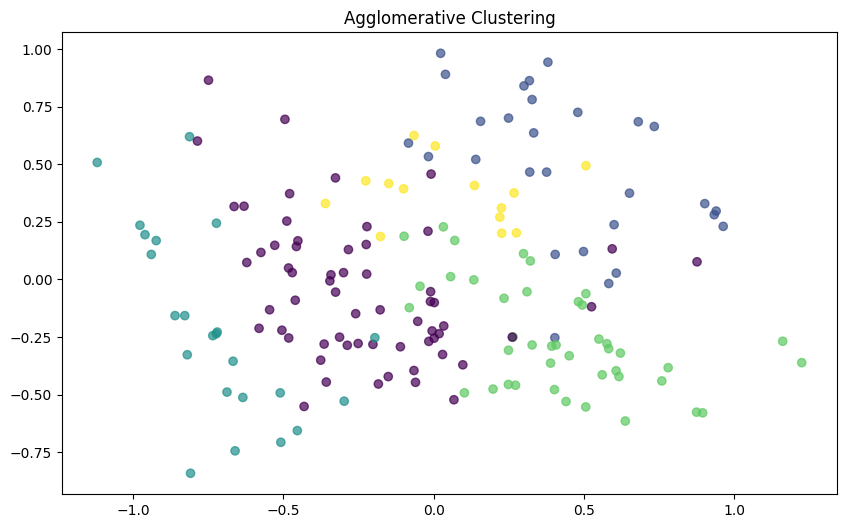

In [60]:
# Clusterize using agglomerative clustering
agglomerative_labels = cluster_ac(x_reduced, n_clusters=5)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=agglomerative_labels, alpha=0.7)
plt.title('Agglomerative Clustering')
plt.show()

In [61]:
print_cluster_stats(labeled_df, agglomerative_labels)

Cluster 0:
Variance for each variable:
step count                                0.224447
distance travelled (km)                   0.202440
calories burnt (kcal)                     0.086925
acive time (minutes)                      0.240192
actual sleep duration (minutes)           0.151711
sleep onset latency (minutes)             0.082373
duration in bed (minutes)                 0.151566
efficiency (%)                            0.094940
in bed time                               0.068418
out bed time                              0.086645
in bed awake duration (minutes)           0.082373
light sleep duration (minutes)            0.174282
deep sleep duration (minutes)             0.124455
REM duration (minutes)                    0.134710
awake percentage (%)                      0.107385
light sleep percentage (%)                0.118664
deep sleep percentage (%)                 0.189024
REM percentage (%)                        0.052384
total phone usage / day (minutes)         0